<a href="https://colab.research.google.com/github/Siddhesh-Agarwal/Tweet-emotion-Recognition/blob/main/my_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nlp
import random

In [45]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [4]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

In [5]:
dataset = nlp.load_dataset("emotion")

In [6]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [8]:
def get_tweet(data):
  tweets = [x["text"] for x in data]
  labels = [x["label"] for x in data]
  return tweets, labels

In [9]:
tweets, labels = get_tweet(train)

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>0')
tokenizer.fit_on_texts(tweets)

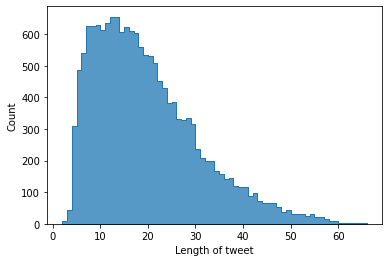

In [11]:
lengths = [len(tweet.split()) for tweet in tweets]
fig = sns.histplot(lengths, bins=len(set(lengths)), element="step")
fig.set(xlabel="Length of tweet", ylabel="Count")
plt.show()

In [12]:
MAX_LENGTH = 60

In [13]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=MAX_LENGTH)
  return padded

In [14]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [15]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

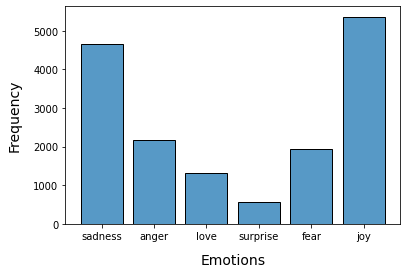

In [16]:
sns.histplot(labels, bins=11, discrete=True, shrink=0.8)
plt.xlabel("Emotions", {"size": 14}, labelpad=12)
plt.ylabel("Frequency", {"size": 14}, labelpad=12)
plt.show()

In [17]:
class_to_index = {c:i for i,c in enumerate(classes)}
index_to_class = {v:k for k,v in class_to_index.items()}
print(class_to_index)
print(index_to_class)

{'love': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'joy': 5}
{0: 'love', 1: 'fear', 2: 'surprise', 3: 'sadness', 4: 'anger', 5: 'joy'}


In [18]:
names_to_IDs = lambda labels: np.array([class_to_index.get(label) for label in labels])

In [19]:
train_labels = names_to_IDs(labels)

In [124]:
model = Sequential([
    Embedding(10000, 16, input_length=MAX_LENGTH),
    Bidirectional(LSTM(20, return_sequences=True)),
    Bidirectional(LSTM(20)),
    Dense(6, activation='softmax'),
])

In [125]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [126]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [127]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_IDs(val_labels)

In [128]:
type(padded_train_seq)

numpy.ndarray

In [129]:
padded_train_seq = np.asarray(padded_train_seq).astype(np.float32)
train_labels = np.asarray(train_labels).astype(np.float32)

In [146]:
model.fit(
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=1)
    ]
  )

Epoch 1/25
500/500 [==============================] - 7s 13ms/step - loss: 0.1406 - accuracy: 0.9553 - val_loss: 0.3991 - val_accuracy: 0.8795
Epoch 2/25
500/500 [==============================] - 7s 13ms/step - loss: 0.1115 - accuracy: 0.9664 - val_loss: 0.4213 - val_accuracy: 0.8800
Epoch 3/25
500/500 [==============================] - 7s 13ms/step - loss: 0.0950 - accuracy: 0.9710 - val_loss: 0.3764 - val_accuracy: 0.8920
Epoch 4/25
500/500 [==============================] - 6s 13ms/step - loss: 0.0888 - accuracy: 0.9719 - val_loss: 0.3748 - val_accuracy: 0.8885


## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

In [147]:
test_tweets, test_labels = get_tweet(test)

In [148]:
test_seq = get_sequences(tokenizer, test_tweets)

In [149]:
test_labels = names_to_IDs(test_labels)

In [150]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 8ms/step - loss: 0.3849 - accuracy: 0.8890


[0.3849203288555145, 0.8889999985694885]

In [151]:
predictions = model.predict(test_seq)

63/63 [==============================] - 0s 5ms/step


In [152]:
predictions = np.argmax(predictions, axis=1)

In [153]:
f"Accuracy: {np.mean(predictions == test_labels, dtype=np.float128, axis=None)*100:.2f}%"

'Accuracy: 88.90%'